In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from collections import deque

# Background Differencing

In [2]:
def background_sub():
    fgbg = cv2.createBackgroundSubtractorMOG2()
    cap = cv2.VideoCapture(0)
  
    while(1):
        ret, frame = cap.read()
        fgmask = fgbg.apply(frame)
        cv2.imshow('frame',fgmask)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            cv2.imshow('frame',fgmask)
            cap.release()
            cv2.destroyAllWindows()
  
    
    

background_sub()





error: OpenCV(3.4.1) C:\Miniconda3\conda-bld\opencv-suite_1533128839831\work\modules\highgui\src\window.cpp:356: error: (-215) size.width>0 && size.height>0 in function cv::imshow


# Skin Color Detection

In [15]:
def mySkinDetect(src):
    # Surveys of skin color modeling and detection techniques:
    # 1. Vezhnevets, Vladimir, Vassili Sazonov, and Alla Andreeva. "A survey on pixel-based skin color detection techniques." Proc. Graphicon. Vol. 3. 2003.
    # 2. Kakumanu, Praveen, Sokratis Makrogiannis, and Nikolaos Bourbakis. "A survey of skin-color modeling and detection methods." Pattern recognition 40.3 (2007): 1106-1122.
    dst = np.zeros((src.shape[0], src.shape[1], 1), dtype = "uint8")
    for i in range(src.shape[0]):
        for j in range(src.shape[1]):
            #b,g,r = src[i,j]
            b = int(src[i,j][0])
            g = int(src[i,j][1])
            r = int(src[i,j][2])
            if(r>95 and g>40 and b>20 and max(r,g,b)-min(r,g,b)>15 and abs(r-g)>15 and r>g and r>b):
                dst[i,j] = 255
    return dst

# frame-to-frame differencing

In [16]:
def myFrameDifferencing(prev, curr):
    # For more information on operation with arrays: 
    # http://docs.opencv.org/modules/core/doc/operations_on_arrays.html
    
    # code here...
    dst = cv2.absdiff(curr, prev)
    dst = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)
    _, dst = cv2.threshold(dst, 50, 255, cv2.THRESH_BINARY)
    
    return dst

# Motion Energy

In [17]:
def myMotionEnergy(mh):
    # the window of time is 3
    mh0 = mh[0]
    mh1 = mh[1]
    mh2 = mh[2]
    dst = np.zeros((mh0.shape[0], mh0.shape[1], 1), dtype = "uint8")
    
    # code here...
    for i in range(dst.shape[0]):
        for j in range(dst.shape[1]):
            if mh0[i, j] ==  255 or mh1[i, j] == 255 or mh2[i, j] == 255:
                dst[i, j] = 255
    
    return dst

# Template Matching

In [2]:
def template_match(img):
    img2 = img.copy()
    template = cv2.imread('fist.png',0)
    cv2.imshow('template',template)
    cv2.imshow('source',img2)
    w, h = template.shape[::-1]
    
    # All the 6 methods for comparison in a list
    methods = ['cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR',
                'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED']

    for meth in methods:
        img = img2.copy()
        method = eval(meth)
      
        # Apply template Matching
        res = cv2.matchTemplate(img,template,method)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

        # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
        if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
            top_left = min_loc
        else:
            top_left = max_loc
        bottom_right = (top_left[0] + w, top_left[1] + h)

        cv2.rectangle(img,top_left, bottom_right, 255, 2)

        plt.subplot(121),plt.imshow(res,cmap = 'gray')
        plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
        plt.subplot(122),plt.imshow(img,cmap = 'gray')
        plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
        plt.suptitle(meth)

        plt.show()

In [19]:
def main():
    # a) Reading a stream of images from a webcamera, and displaying the video
    # open the video camera no. 0
    # for more information on reading and writing video: http://docs.opencv.org/modules/highgui/doc/reading_and_writing_images_and_video.html
    cap = cv2.VideoCapture(0)
    
    #if not successful, exit program
    if not cap.isOpened():
        print("Cannot open the video cam")
        return -1

    # read a new frame from video
    success, prev_frame = cap.read()
    
    #if not successful, exit program
    if not success:
        print("Cannot read a frame from video stream")
        return -1
    cv2.namedWindow("frame", cv2.WINDOW_AUTOSIZE)
    
    prev_frame = cv2.resize(prev_frame,(150,150))
    fMH1 = np.zeros((prev_frame.shape[0], prev_frame.shape[1], 1), dtype = "uint8")
    fMH2 = fMH1.copy()
    fMH3 = fMH1.copy()
    myMotionHistory = deque([fMH1, fMH2, fMH3]) 
    while(True):
        #read a new frame from video
        success, curr_frame = cap.read()
        curr_frame = cv2.resize(curr_frame,(150,150))
        if not success:
            print("Cannot read a frame from video stream")
            break
    
        #cv2.imshow('frame',curr_frame)

        # b) Skin color detection
        mySkin = mySkinDetect(curr_frame)
        #cv2.imshow('mySkinDetect',mySkin)

        # c) Background differencing
        frameDest = myFrameDifferencing(prev_frame, curr_frame)
        #cv2.imshow('myFrameDifferencing',frameDest)

        # d) Visualizing motion history
        myMotionHistory.popleft()
        myMotionHistory.append(frameDest)
        myMH = myMotionEnergy(myMotionHistory)
        #cv2.imshow('myMotionHistory',myMH)
        
        # e) template matching
        frameDest.astype(np.uint8)
        template_match(frameDest)
       
        
        prev_frame = curr_frame
        
        
        # wait for 'q' key press. If 'q' key is pressed, break loop
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()
    cv2.waitKey(1)
    return 0
    

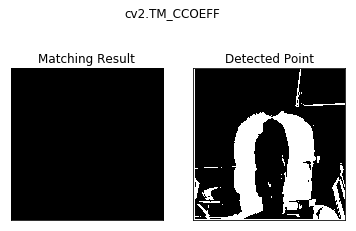

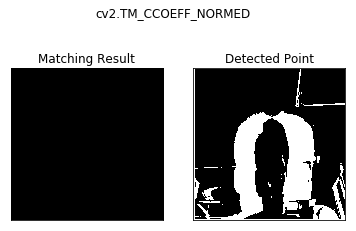

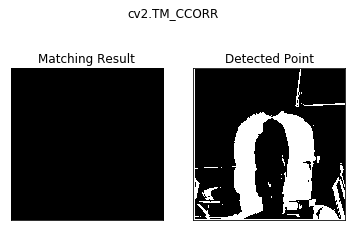

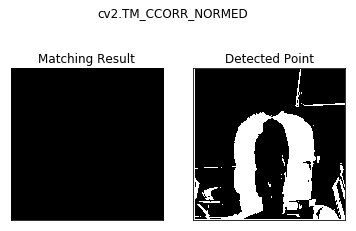

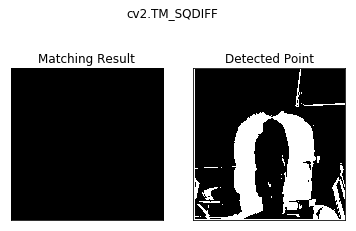

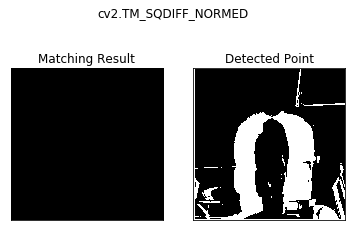

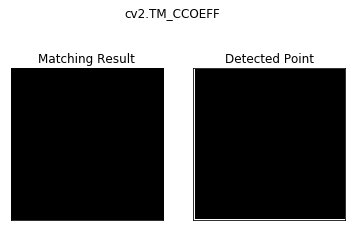

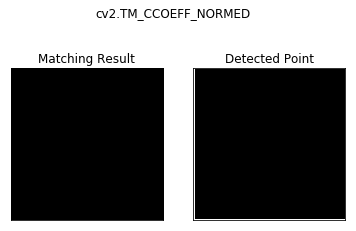

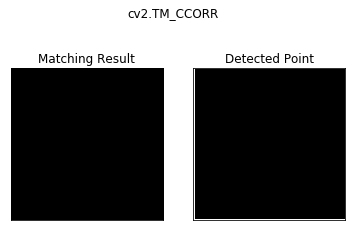

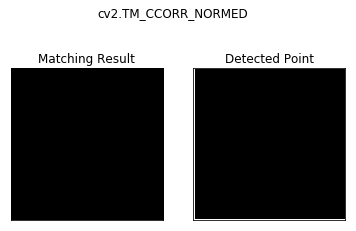

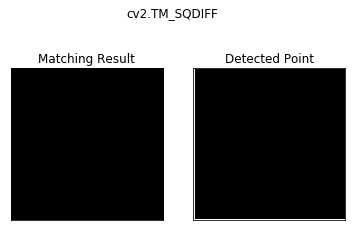

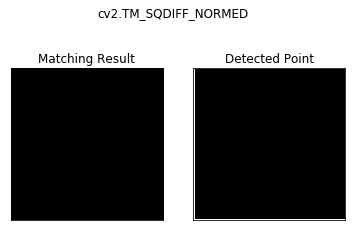

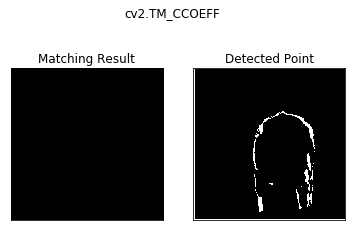

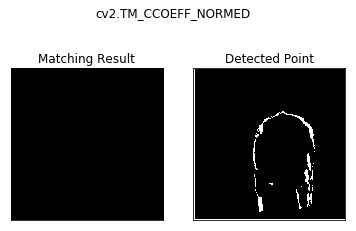

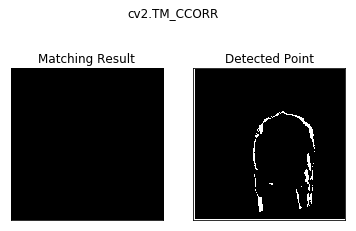

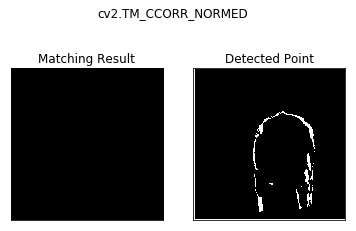

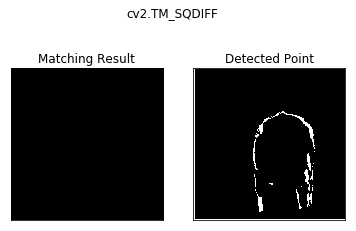

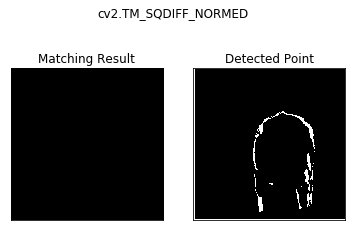

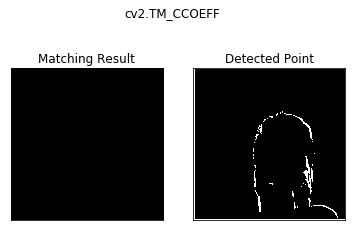

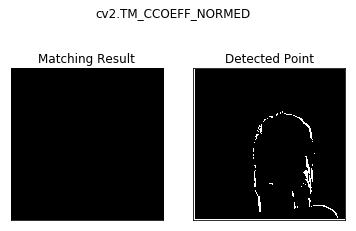

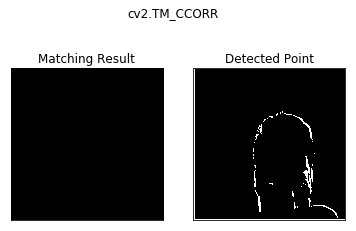

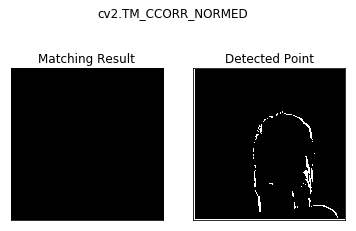

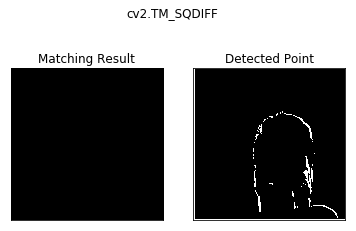

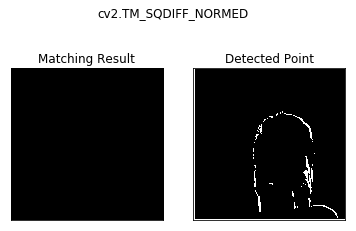

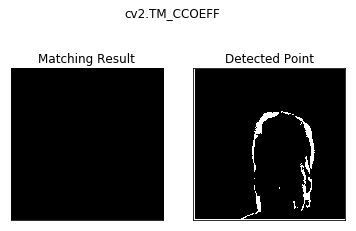

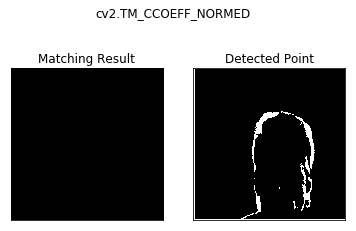

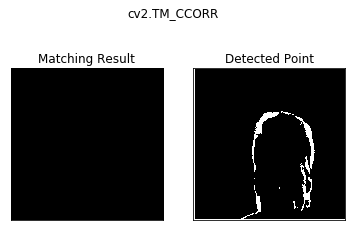

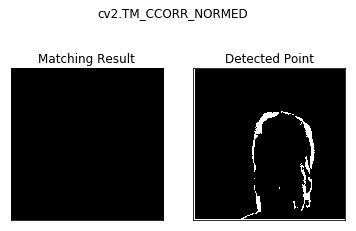

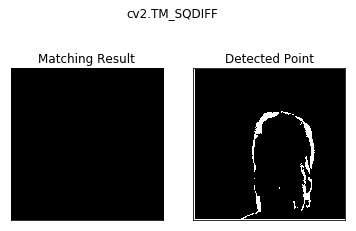

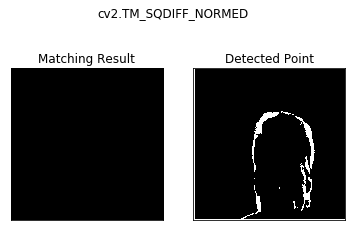

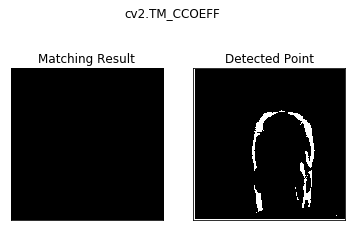

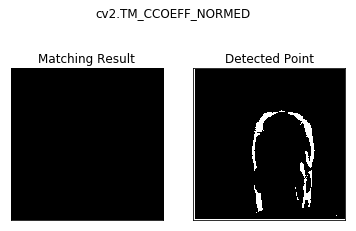

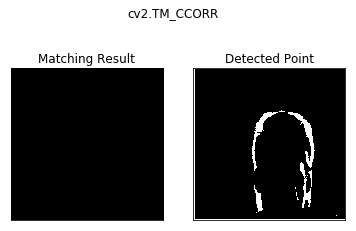

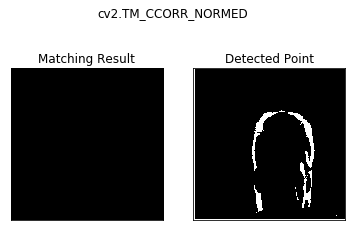

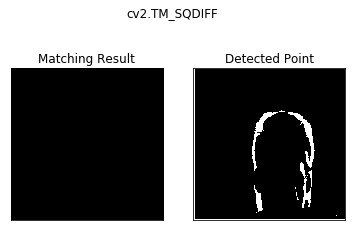

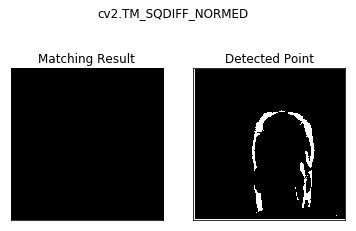

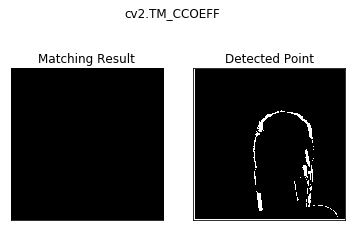

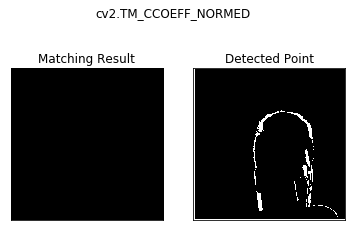

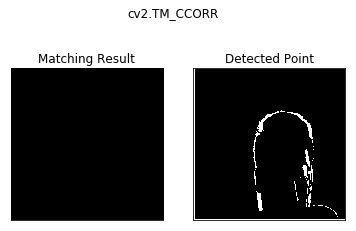

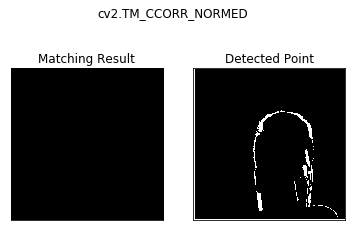

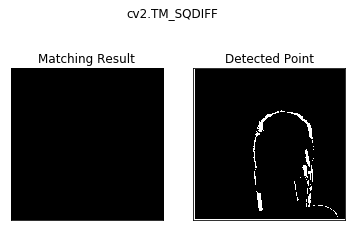

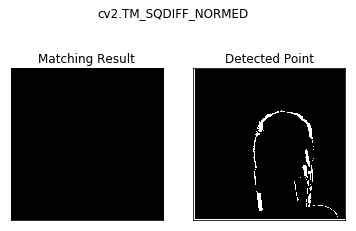

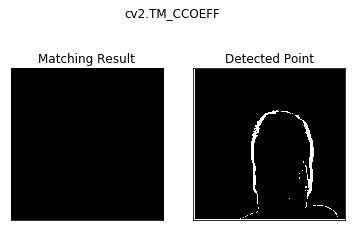

KeyboardInterrupt: 

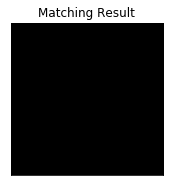

In [20]:
if __name__ == "__main__":
    main()

In [6]:
def main2():
    # a) Reading a stream of images from a webcamera, and displaying the video
    # open the video camera no. 0
    # for more information on reading and writing video: http://docs.opencv.org/modules/highgui/doc/reading_and_writing_images_and_video.html
    cap = cv2.VideoCapture(0)
    fgbg = cv2.createBackgroundSubtractorMOG2()
    #if not successful, exit program
    if not cap.isOpened():
        print("Cannot open the video cam")
        return -1

    while(True):
        #read a new frame from video
        ret, frame = cap.read()
        if not ret:
            print("Cannot read a frame from video stream")
            break
    

        # e) template matching
       


        fgmask = fgbg.apply(frame)
        cv2.imshow('frame',fgmask)
        fgmask.astype(np.uint8)
        template_match(fgmask)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()
    return 0
    

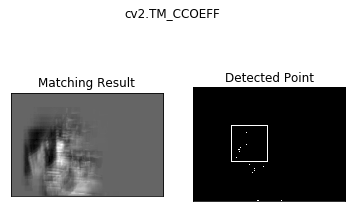

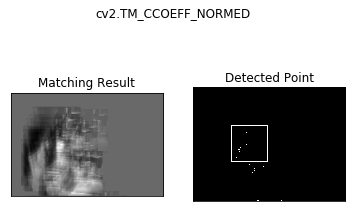

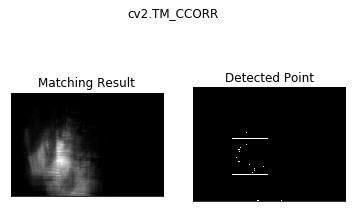

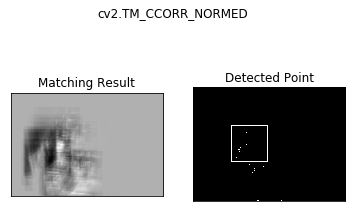

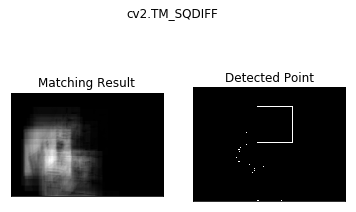

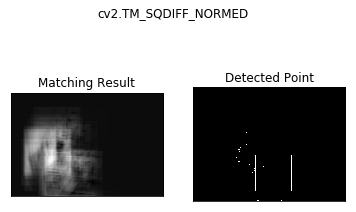

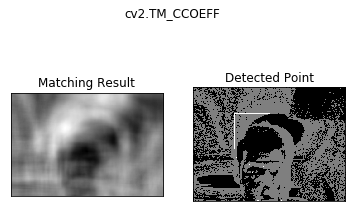

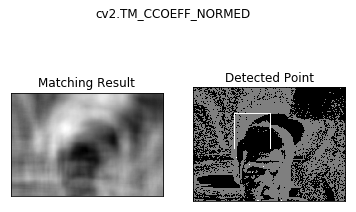

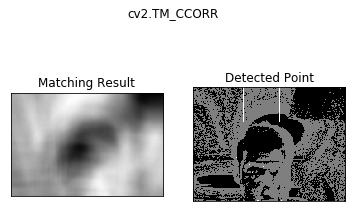

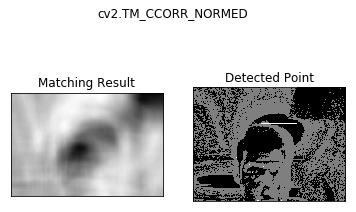

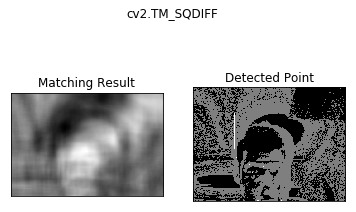

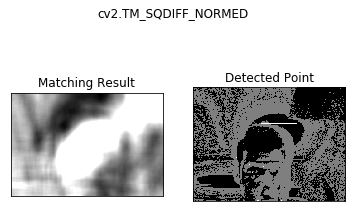

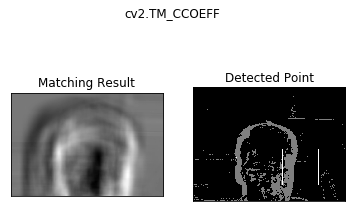

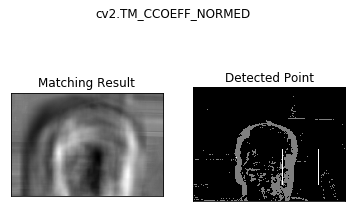

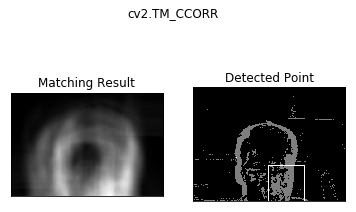

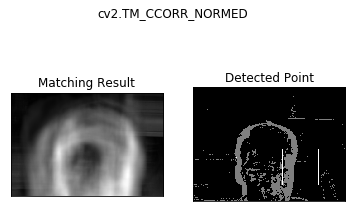

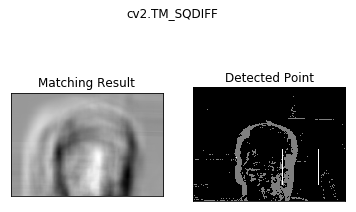

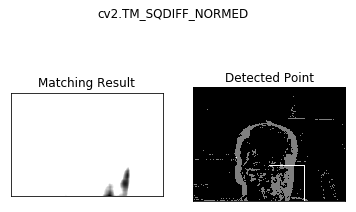

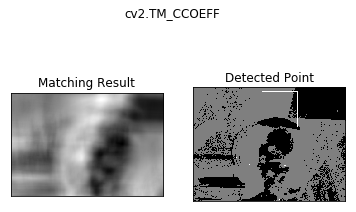

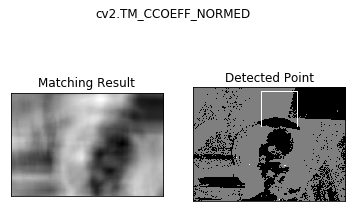

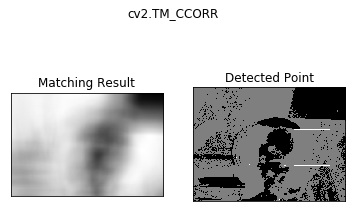

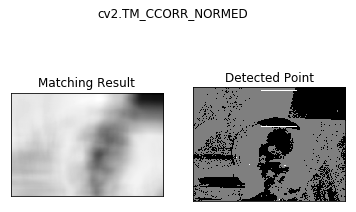

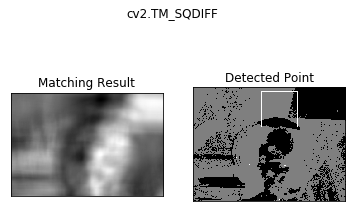

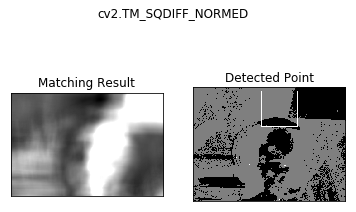

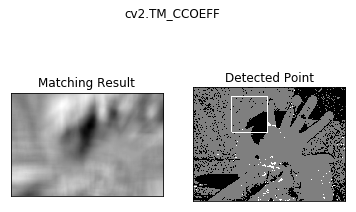

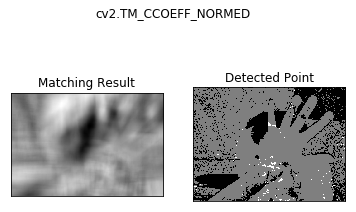

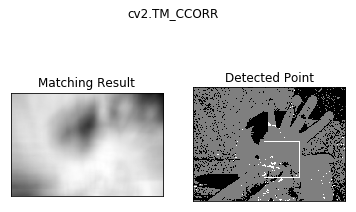

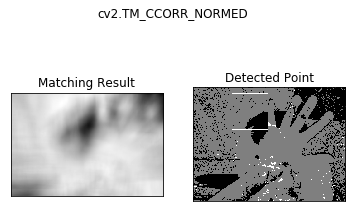

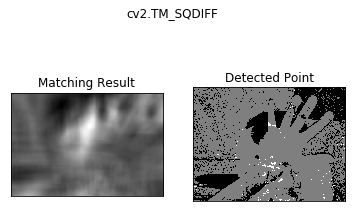

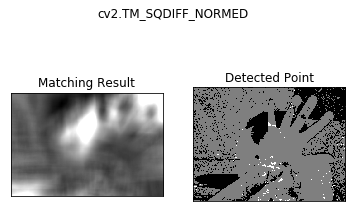

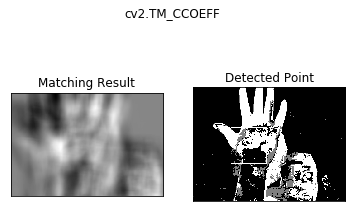

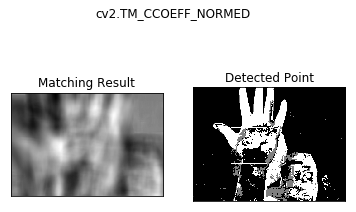

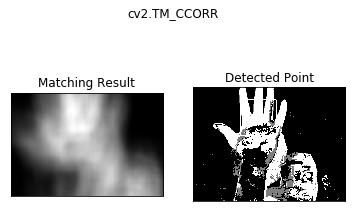

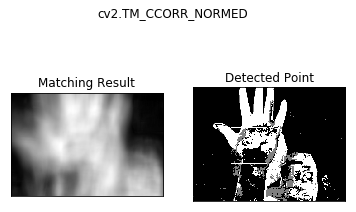

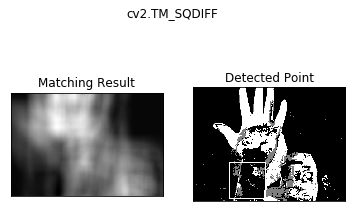

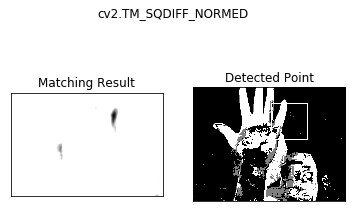

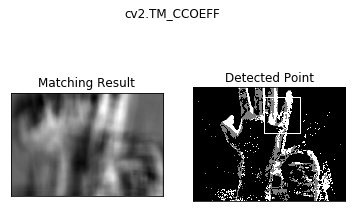

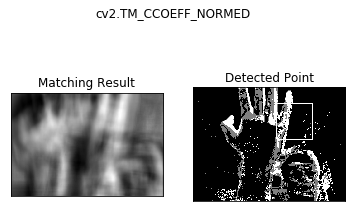

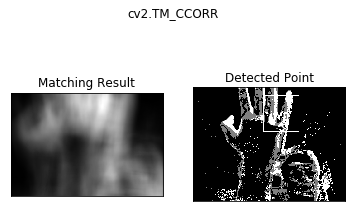

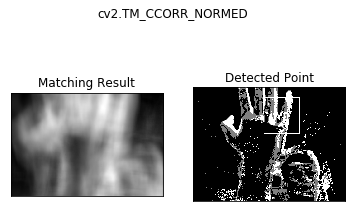

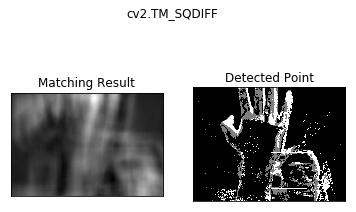

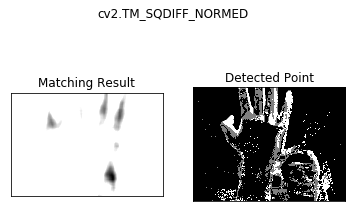

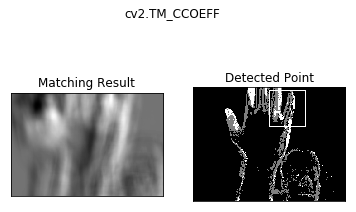

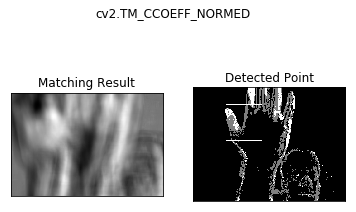

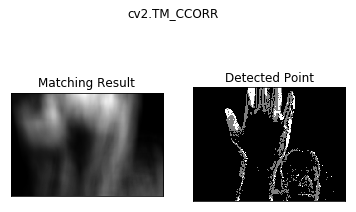

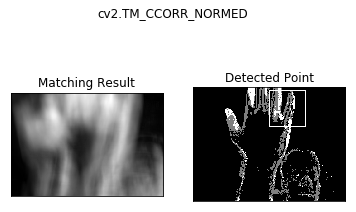

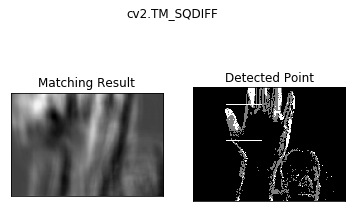

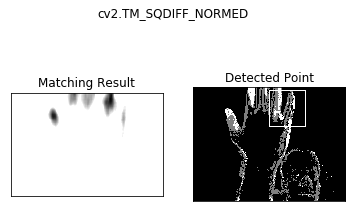

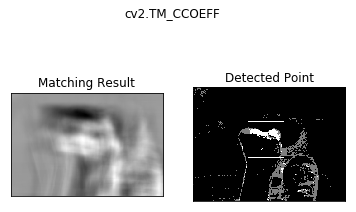

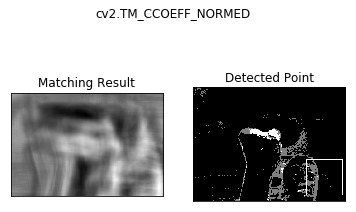

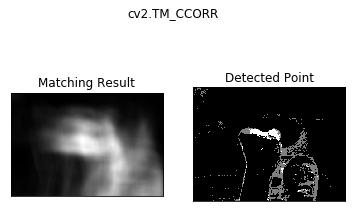

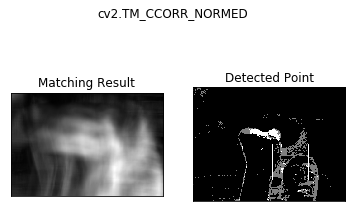

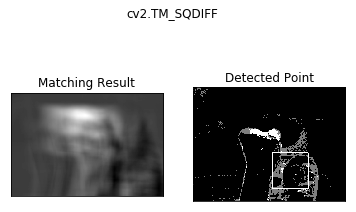

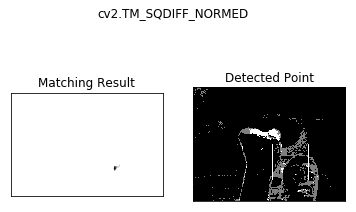

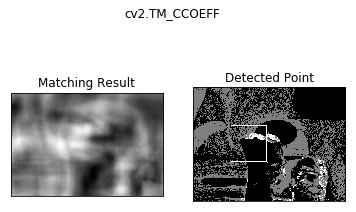

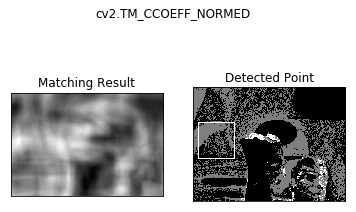

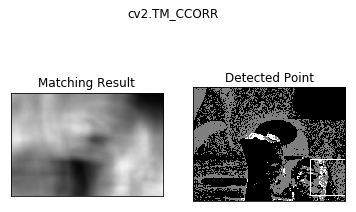

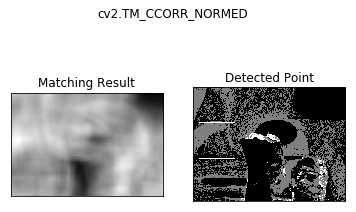

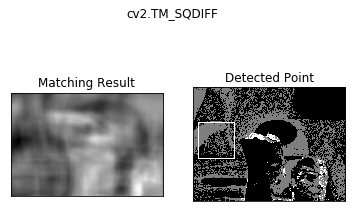

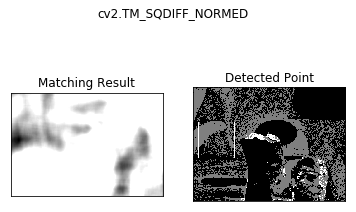

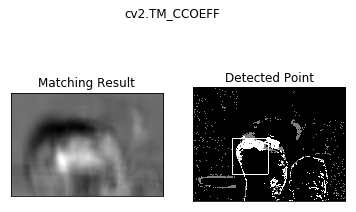

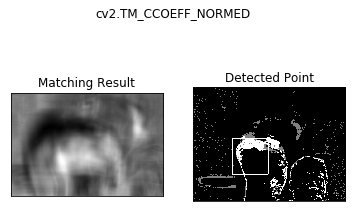

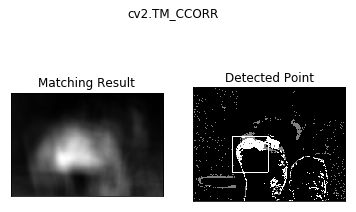

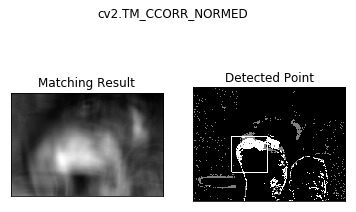

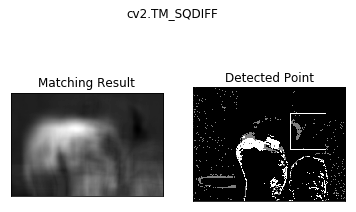

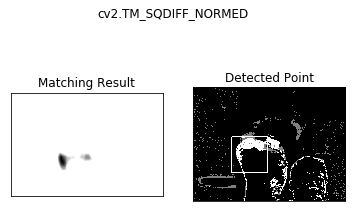

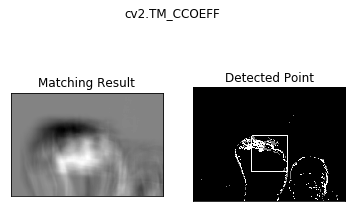

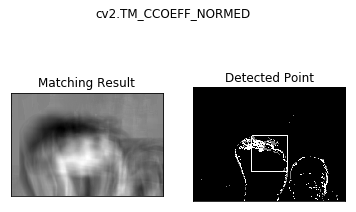

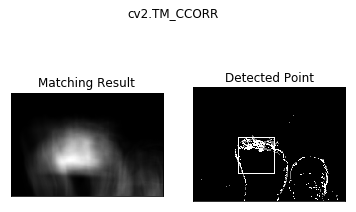

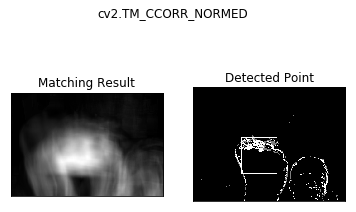

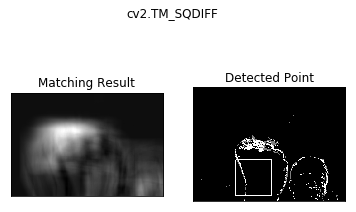

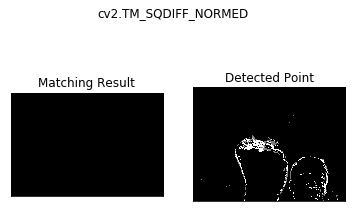

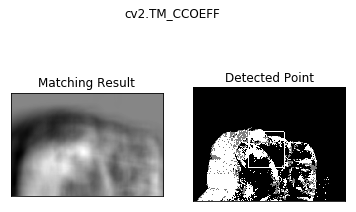

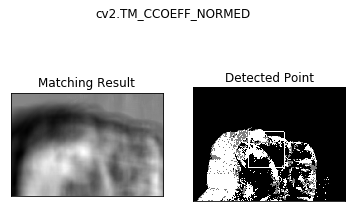

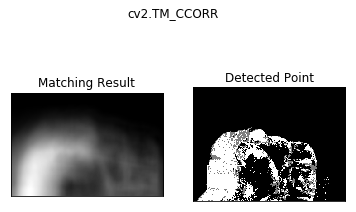

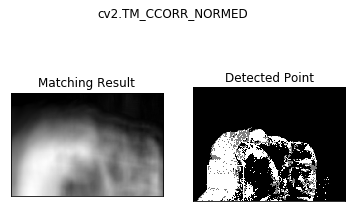

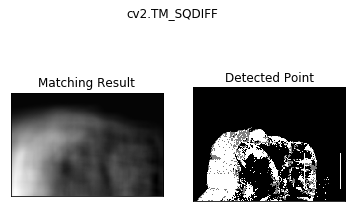

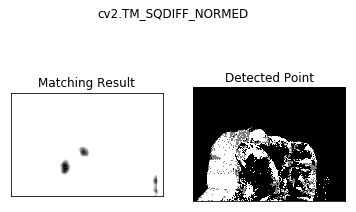

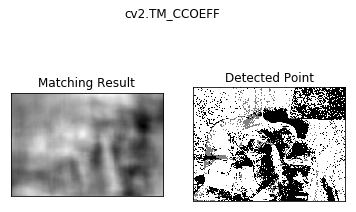

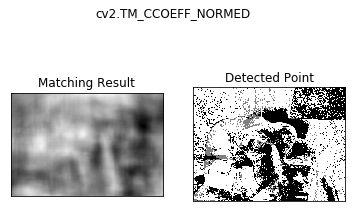

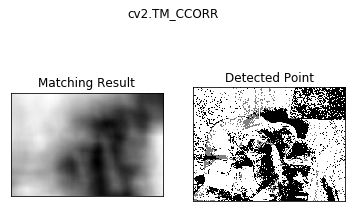

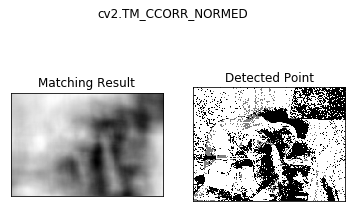

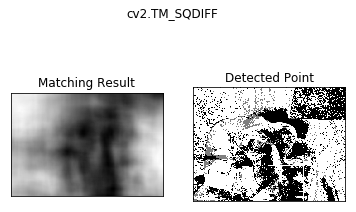

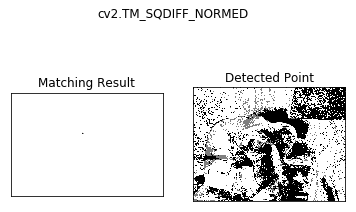

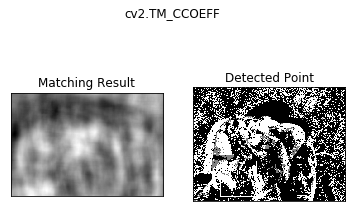

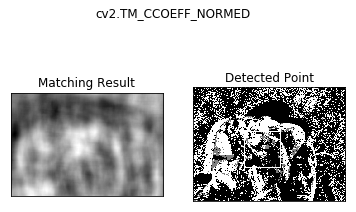

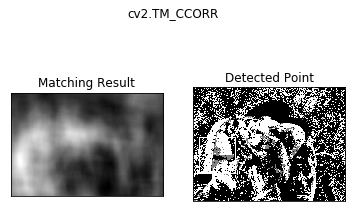

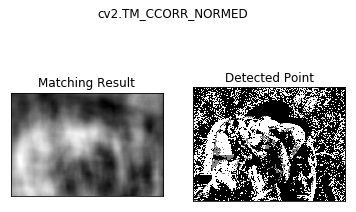

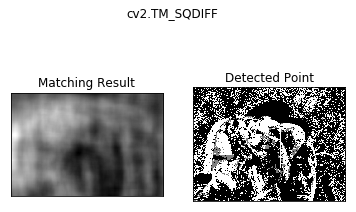

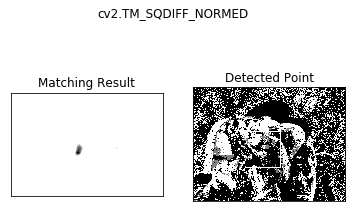

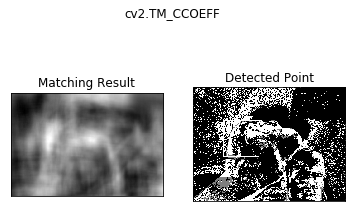

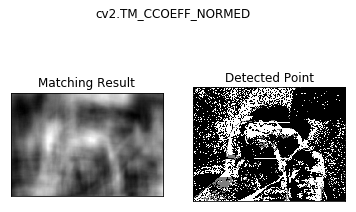

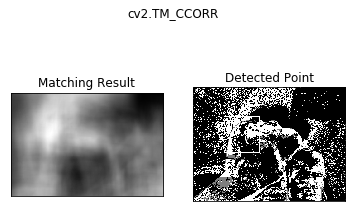

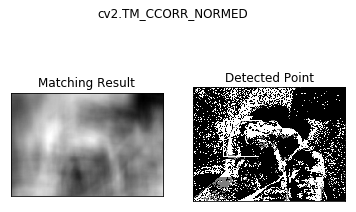

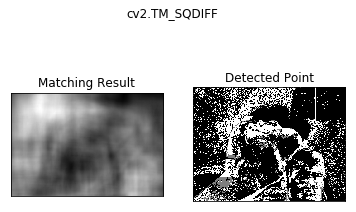

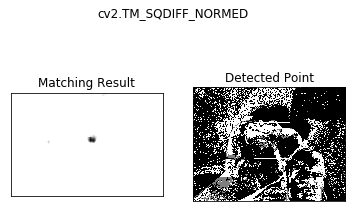

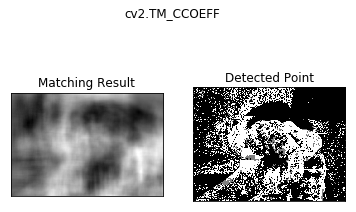

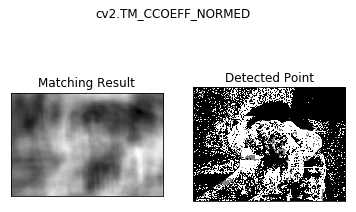

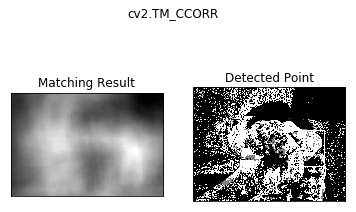

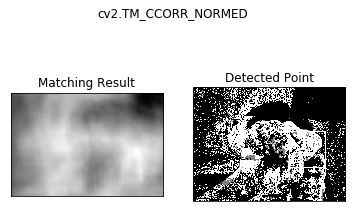

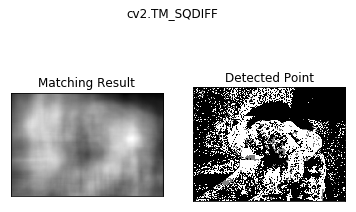

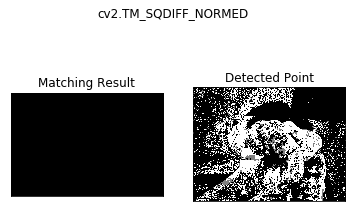

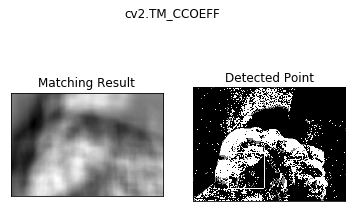

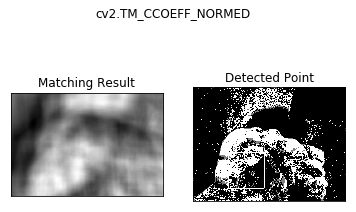

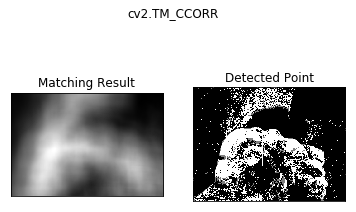

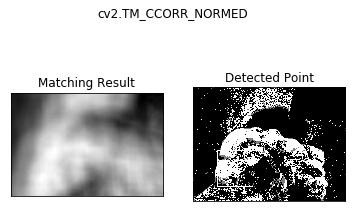

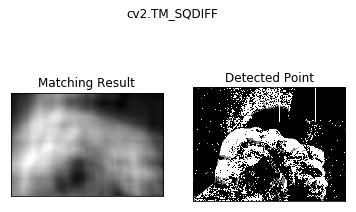

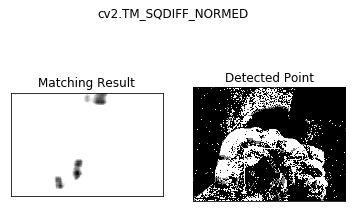

0

In [7]:
main2()